# Feature Engineering & Preprocessing

The purpose of this notebook is to come up with some interesting features and to deal with data cleaning, standardization, outlier removal, etc.

In [1]:
from toxic import common

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import string

%xmode plain
%matplotlib inline
sns.set()
# sns.set_style('darkgrid')

from IPython.display import display

from collections import OrderedDict
from sklearn.neighbors import LocalOutlierFactor

Exception reporting mode: Plain


# The Data

In [2]:
# train = common.gcs_to_df(blob='train.csv').set_index('id')
# test = common.gcs_to_df(blob='test.csv').set_index('id')
train = pd.read_csv('train.csv', index_col='id')

In [3]:
train['is_toxic'] = train.loc[:, 'toxic':'identity_hate'].any(axis=1)
target = train.loc[:, 'toxic':'identity_hate']
train.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,is_toxic
id,,,,,,,,
22256635,"Nonsense? kiss off, geek. what I said is true...",1,0,0,0,0,0,True
27450690,"""\n\n Please do not vandalize pages, as you di...",0,0,0,0,0,0,False
54037174,"""\n\n """"Points of interest"""" \n\nI removed the...",0,0,0,0,0,0,False
77493077,Asking some his nationality is a Racial offenc...,0,0,0,0,0,0,False
79357270,The reader here is not going by my say so for ...,0,0,0,0,0,0,False


# Best Parameters for Vectorization

We would like to know the optimal representation of the term-document matrix. The best representation should minimize the loss of information which is related to our targets, so we can evaluate alternate term-document representations by scoring the predictions from a basic logistic regression.

In [4]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
corpus = train['comment_text']
vectorizer = CountVectorizer(max_features=100, stop_words='english')
vectorizer.fit(corpus)
sparse = vectorizer.transform(corpus)

In [5]:
sparse[:5]

<5x100 sparse matrix of type '<class 'numpy.int64'>'
	with 25 stored elements in Compressed Sparse Row format>

In [6]:
sparse[:, [1,2]]

<95851x2 sparse matrix of type '<class 'numpy.int64'>'
	with 7839 stored elements in Compressed Sparse Row format>

In [7]:

from toxic.common import Stemmer
stemmer = Stemmer(stemming='snowball')
vocab_stemmed, sparse_stemmed = stemmer.transform(
    td_matrix=sparse, 
    vocab=vectorizer.vocabulary_)

Creating variables...
Stemming vocabulary...
Combining stem facet vectors...
shape of empty matrix res: (95851, 0)
Summing across stem facets...
result stack shape: (95851, 85)
Sorting result matrix...
sorted index shape: (85,)
sorted index: [42 24 27 23 48  3 28  7 36 53 30 63 57 15 61 80 25 16 39  9 12 47 65 77  6
 26 64 40 58 41 52  4 75 35  1 49 19 81 38  5 84 59 54 55 71 68 62 33 60 13
 44 76 67 78 73 37 72 66 79  8 45 32 69 46 51 74 83 29 20 31 14 22 43 21 10
 50 56  2 11 82 18 17  0 34 70]
Sorting vocabulary


In [8]:
vocab_stemmed

array(['articl', 'page', 'wikipedia', 'edit', 'talk', 'use', 'like',
       'just', 'thank', 'don', 'sourc', 'delet', 'think', 'know', 'peopl',
       'time', 'did', 'block', 'user', 'link', 'make', 'good', 'inform',
       've', 'person', 'doe', 'comment', 'want', 'question', 'way', 'imag',
       'thing', 'fuck', 'wp', 'help', 'new', 'need', 'say', 'section',
       'discuss', 'realli', 'work', 'right', 'wiki', 'point', 'add',
       'read', 'look', 'fact', 'll', 'said', 'list', 'go', 'content',
       'stop', 'hi', 'histori', 'ad', 'http', 'editor', 'utc', 'remov',
       'free', 'note', 'welcom', 'vandal', 'case', 'place', 'doesn',
       'sure', 'reason', 'better', 'let', 'ask', 'feel', 'believ',
       'actual', 'subject', 'best', 'polici', 'nigger', 'hope', 'com',
       'didn', 'chang'],
      dtype='<U9')

In [ ]:
sparse_stemmed.sum(axis=0)

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.pipeline import Pipeline

from toxic.common import Stemmer

max_features = [None]
max_features.extend(np.logspace(0, 5, 10, dtype=np.float64).astype(int))

param_grid = [
    {
        'vectorizer': [CountVectorizer()],
        'vectorizer__ngram_range': [(1,1), (1,2)],
        'vectorizer__stop_words': ['english', None],
        'vectorizer__binary': [False, True],
#         'vectorizer__lowercase': [True, False],
#         'vectorizer__max_df': np.linspace(0, 1, 5),
#         'vectorizer__min_df': np.linspace(0, 1, 5),
        'vectorizer__max_features': max_features,
        
        'stemmer':[Stemmer()],
        'stemmer__stemming': ['lancaster', 'snowball', 'wordnet'],
        
#         'model': [LogisticRegression()]
        
    },
    {
        'vectorizer': [TfidfVectorizer()],
        'vectorizer__ngram_range': [(1,1), (1,2)],
        'vectorizer__stop_words': ['english', None],
        'vectorizer__binary': [False, True],
        'vectorizer__lowercase': [True, False],
#         'vectorizer__max_df': np.linspace(0, 1, 5),
#         'vectorizer__min_df': np.linspace(0, 1, 5),
        'vectorizer__max_features': max_features,
        'vectorizer__norm': [None, 'l1', 'l2'],
        'vectorizer__use_idf': [False, True],
        'vectorizer__smooth_idf': [False, True],
        'vectorizer__sublinar_tf': [False, True],
        
        'stemmer': [Stemmer()],
        'stemmer__stemming': ['lancaster', 'snowball', 'wordnet'],
        
#         'model': [LogisticRegression()]
    },
]

textRepresentationPipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('stemmer', Stemmer()),
    ('model', LogisticRegression_mod())
])

grid = GridSearchCV(
    textRepresentationPipeline, 
    param_grid=param_grid, 
    cv=3, 
#     n_jobs=6, 
    verbose=10)

In [11]:
%xmode plain
# %xmode verbose
from sklearn.metrics import log_loss

grid.fit(corpus.values, target)

Exception reporting mode: Plain
Fitting 3 folds for each of 12936 candidates, totalling 38808 fits
[CV] vectorizer__ngram_range=(1, 1), stemmer=Stemmer(stemming='lancaster'), vectorizer__stop_words=english, vectorizer=CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None), stemmer__stemming=lancaster, vectorizer__binary=False, vectorizer__max_features=None 


TypeError: transform() takes 1 positional argument but 2 were given

In [27]:
grid.predict_proba(corpus)

NotFittedError: This GridSearchCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

# Comment Length


## Characters


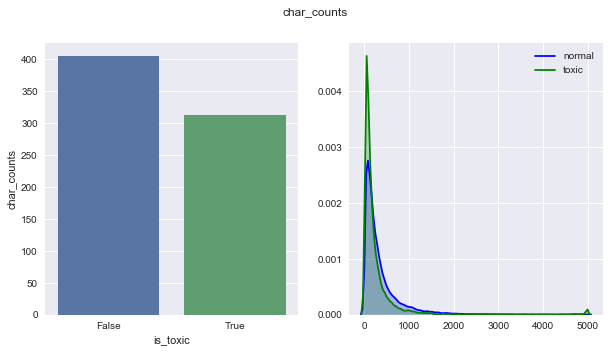

In [4]:
train['char_counts'] = train['comment_text'].str.len()
fig = common.density_plot(train, 'char_counts', train['is_toxic']);
fig.suptitle('char_counts');

In [5]:
train['char_counts'].describe().astype(int)

count    95851
mean       395
std        595
min          6
25%         96
50%        206
75%        435
max       5000
Name: char_counts, dtype: int32

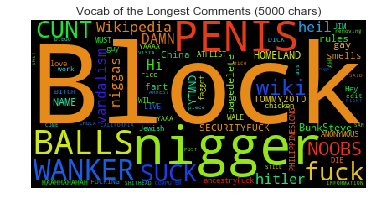

In [6]:
long = train['comment_text'][train['char_counts']==train['char_counts'].max()]
f = plt.figure()
ax = plt.subplot(111)
ax = common.plot_wordcloud_to_axis(' '.join(long.values), ax=ax);
ax.set_title('Vocab of the Longest Comments (5000 chars)');

KeyboardInterrupt: 

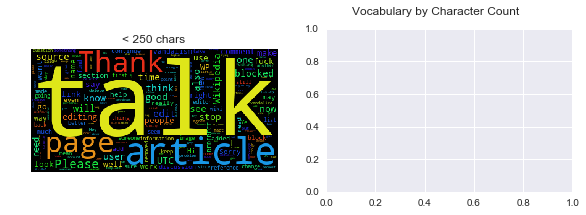

In [7]:
f = plt.figure(figsize=(15,3))
f.suptitle('Vocabulary by Character Count')

short = train['comment_text'][(train['char_counts'] < 250)]
long = train['comment_text'][(train['char_counts'] >= 250) & (train['char_counts'] < 3000)]
extralong = train['comment_text'][(train['char_counts'] >= 3000)]

ax1 = plt.subplot(int(str(13) + str(1)))
ax1 = common.plot_wordcloud_to_axis(' '.join(short.values), ax=ax1)
ax1.set_title('< 250 chars')

ax2 = plt.subplot(int(str(13) + str(2)))
ax2 = common.plot_wordcloud_to_axis(' '.join(long.values), ax=ax2);
ax2.set_title('250-3000 chars')

ax3 = plt.subplot(int(str(13) + str(3)))
ax3 = common.plot_wordcloud_to_axis(' '.join(extralong.values), ax=ax3);
ax3.set_title('> 3000 chars');

Note above that there is a stark difference in topic for short vs. medium vs. long comments.

## Lines


In [ ]:
train['line_counts'] = train['comment_text'].str.split('\n').apply(lambda x: len(x))
fig = common.density_plot(train, 'line_counts', train['is_toxic']);
fig.suptitle('line_counts');

In [ ]:
train['line_counts'].describe(percentiles=[.98]).astype(int)

## Words

In [ ]:
train['word_counts'] = train['comment_text'].str.split().apply(lambda x: len(x))
fig = common.density_plot(train, 'word_counts', train['is_toxic']);
fig.suptitle('word_counts');

In [ ]:
train['word_counts'].describe().astype(int)

## Word Length

In [ ]:
train['word_lengths'] = train['char_counts']/train['word_counts']
fig = common.density_plot(train, 'word_lengths', train['is_toxic']);
fig.suptitle('word_lengths');

In [ ]:
train['word_lengths'].describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.99]).astype(int)

In [ ]:
normal_max = train.loc[~train['is_toxic'], 'word_lengths'].max()
toxic_max = train.loc[train['is_toxic'], 'word_lengths'].max()
train.loc[train['word_lengths'].isin([normal_max, toxic_max])]

In [ ]:
train.groupby('is_toxic').median()['word_lengths']

In [ ]:
train['word_lengths'].sort_values(ascending=False).head()

## Paragraphs

In [ ]:
train['paragraphs'] = train['comment_text'].str.split('\n{1,}').apply(lambda x: len(x))
fig = common.density_plot(train, 'paragraphs', train['is_toxic']);
fig.suptitle('paragraphs');

In [ ]:
train['paragraph_lengths'] = train['word_counts']/train['paragraphs']
fig = common.density_plot(train, 'paragraph_lengths', train['is_toxic']);
fig.suptitle('paragraph_lengths');

# Textual Screaming

In [ ]:
def str_to_prop_caps(s=None, base='letters'):
    '''Returns the proportion of 
    letters in a string which are uppercase'''
    num_caps = len(list(filter(lambda x: x in string.ascii_uppercase, s)))
    total_chars = len(s)
    total_letters = len(list(filter(lambda x: x in string.ascii_letters, s)))
    if base == 'letters':
        try: 
            return num_caps / total_letters
        except ZeroDivisionError:
            return 0
    elif base == 'chars':
        try: 
            return num_caps / total_chars
        except ZeroDivisionError:
            return 0
    else:
        raise ValueError('Unrecognized base')

# str_to_prop_caps('hElO')

In [ ]:
train['prop_caps'] = train['comment_text'].apply(str_to_prop_caps)

In [ ]:
train.prop_caps.describe()

In [ ]:
f = plt.figure(figsize=(15,3))
f.suptitle('Vocabulary by Proportion Caps')

quiet = train.loc[train['prop_caps'] < train['prop_caps'].median(), 'comment_text']
loud = train.loc[train['prop_caps'] > np.percentile(train['prop_caps'], q=-.95), 'comment_text']

ax = plt.subplot(121)
ax.

## Outliers

In [ ]:
length_measures = [
    'char_counts',
    'line_counts', 
    'word_counts', 
    'word_lengths', 
    'paragraphs', 
    'paragraph_lengths',
    'is_toxic'
]

sns.heatmap(train[length_measures].corr());

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
counts_lengths_std = scaler.fit_transform(counts_lengths)

from sklearn.decomposition import PCA
pca = PCA(
    n_components=2,
    random_state=42
)
pca.fit(counts_lengths_std)

In [ ]:
counts_lengths_std.std(axis=0)

In [ ]:
list(zip(pca.components_))

In [ ]:
comps = pd.DataFrame(
    pca.transform(counts_lengths_std), 
    columns=['PC1', 'PC2'],
    index=train.index
)
comps = comps.join(train['is_toxic'])
fig = sns.lmplot(x='PC1', y='PC2', hue='is_toxic', data=comps, fit_reg=False)
# fig.axes[0][0].arrow(0, 0, pca.components_[0][0], pca.components_[1][0])
for variable in list(zip(pca.components_[0], pca.components_[1])):
    norm = np.sqrt(variable[0]**2 + variable[1]**2)
    fig.axes[0][0].arrow(0, 0, variable[0]*norm*100, variable[1]*norm*100)
    
    


In [ ]:
plot_pca_loadings(component=1, data=counts_lengths_std)

In [ ]:
plot_pca_loadings(component=2, data=counts_lengths_std)

In [ ]:
plot_pca_loadings(component=3, data=counts_lengths_std)

In [ ]:
sns.lmplot(
    x='word_counts', 
    y='char_counts', 
    data=train, 
    fit_reg=False, 
    hue='is_toxic');

Above, notice the character-count ceiling at 5000 characters. It's not clear at this time whether this is a limit imposed by Wikipedia or by the gatherers of the dataset.

In [ ]:
sns.lmplot(
    x='word_counts', 
    y='word_lengths',
    data=train, 
    fit_reg=False, 
    hue='is_toxic');

In [ ]:
sns.lmplot(
    x='char_counts', 
    y='line_counts',
    data=train, 
    fit_reg=False, 
    hue='is_toxic');

# 'char_counts', 
# 'line_counts'
# 'word_counts',
# 'word_lengths', 
# 'paragraphs', 
# 'paragraph_lengths'

In [ ]:
sns.lmplot(
    x='char_counts', 
    y='word_lengths',
    data=train, 
    fit_reg=False, 
    hue='is_toxic');

# 'char_counts', 
# 'line_counts'
# 'word_counts',
# 'word_lengths', 
# 'paragraphs', 
# 'paragraph_lengths'

In [ ]:
train[train['char_counts']==5000].head()